In [1]:
import csv
import os
import argparse
import torch
from transformers import GPT2Tokenizer, GPT2LMHeadModel
import numpy as np
from torch.utils.data import Dataset, DataLoader
from transformers import AdamW, get_cosine_with_hard_restarts_schedule_with_warmup
import warnings
warnings.filterwarnings('ignore')

In [2]:
class MyDataset(Dataset):
    def __init__(self, data_file_name, data_dir='./data'):
        super().__init__()

        data_path = os.path.join(data_file_name)

        self.data_list = []
        self.end_of_text_token = " <|endoftext|> "

        with open(data_path) as csv_file:
            csv_reader = csv.reader(csv_file, delimiter='\t')

            for row in csv_reader:
                data_str = f"{row[0]}: {row[1]}{self.end_of_text_token}"
                self.data_list.append(data_str)
                

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, item):
        return self.data_list[item]

In [3]:
def get_data_loader(data_file_name):
    dataset = MyDataset(data_file_name)
    data_loader = DataLoader(dataset, batch_size=1, shuffle=True)
    return data_loader

def train(epochs, data_loader, batch_size, tokenizer, model, device):	
    batch_counter = 0
    sum_loss = 0.0

    for epoch in range(epochs):
        print (f'Running {epoch+1} epoch')

        for idx, txt in enumerate(data_loader):
            txt = torch.tensor(tokenizer.encode(txt[0]))
            txt = txt.unsqueeze(0).to(device)
            outputs = model(txt, labels=txt)
            loss, _ = outputs[:2]
            loss.backward()
            sum_loss += loss.data

            if idx%batch_size==0:
                batch_counter += 1
                optimizer.step()
                scheduler.step()
                optimizer.zero_grad()
                model.zero_grad()

            if batch_counter == 10:
                print(f"Total Loss is {sum_loss}") #printed after every 10*batch_size
                batch_counter = 0
                sum_loss = 0.0

    return model

def save_model(model, name):
    """
    Summary:
        Saving model to the Disk
    Parameters:
        model: Trained model object
        name: Name of the model to be saved
    """
    print ("Saving model to Disk")
    torch.save(model.state_dict(), f"{name}.pt")
    return

def load_models():
    """
    Summary:
        Loading Pre-trained model
    """
    print ('Loading/Downloading GPT-2 Model')
    tokenizer = GPT2Tokenizer.from_pretrained('gpt2-medium')
    model = GPT2LMHeadModel.from_pretrained('gpt2-medium')
    return tokenizer, model


In [4]:
BATCH_SIZE = 32
EPOCHS = 3
LEARNING_RATE = 3e-5
WARMUP_STEPS = 300
MAX_SEQ_LEN = 200
MODEL_NAME = 'crisis_gpt2_model.pt'
DATA_FILE = 'crisis_gpt2.csv'

In [5]:
TOKENIZER, MODEL = load_models()

Loading/Downloading GPT-2 Model


In [6]:
LOADER = get_data_loader(DATA_FILE)

In [7]:
DEVICE = 'cpu'
if torch.cuda.is_available():
    DEVICE = 'cuda'

In [8]:
model = MODEL.to(DEVICE)

In [9]:
model.train()

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 1024)
    (wpe): Embedding(1024, 1024)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): GPT2Block(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): GPT2Block(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout)

In [10]:
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
scheduler = get_cosine_with_hard_restarts_schedule_with_warmup(optimizer, num_warmup_steps=WARMUP_STEPS, num_training_steps=-1)
model = train(EPOCHS, LOADER, BATCH_SIZE, TOKENIZER, MODEL, DEVICE)

Running 1 epoch
Total Loss is 1653.375
Total Loss is 1738.4769287109375
Total Loss is 1622.9844970703125
Total Loss is 1443.571044921875
Total Loss is 1279.154296875
Total Loss is 1087.4747314453125
Total Loss is 985.4525756835938
Total Loss is 926.0236206054688
Total Loss is 900.540771484375
Total Loss is 872.2272338867188
Total Loss is 879.2655639648438
Total Loss is 855.2831420898438
Total Loss is 819.8289184570312
Total Loss is 833.469970703125
Total Loss is 806.9989624023438
Total Loss is 811.0712280273438
Total Loss is 816.1663818359375
Running 2 epoch
Total Loss is 757.6914672851562
Total Loss is 788.139404296875
Total Loss is 775.0728149414062
Total Loss is 768.745849609375
Total Loss is 780.6782836914062
Total Loss is 759.34130859375
Total Loss is 742.1080322265625
Total Loss is 746.1094970703125
Total Loss is 763.0253295898438
Total Loss is 761.704833984375
Total Loss is 736.750244140625
Total Loss is 733.6726684570312
Total Loss is 740.0639038085938
Total Loss is 735.7160034

In [11]:
save_model(model, MODEL_NAME)

Saving model to Disk


In [12]:
save_model(model,'crisis_gpt2_model')

Saving model to Disk


In [31]:
import pandas as pd
import matplotlib.pyplot as plt

In [64]:
df = pd.read_excel("./report/balanced_report_1.xlsx")
df.head(5)

,Classifier,E_F1 Score,F_F1 Score,H_F1 Score,W_F1 Score
0,Logistic Regression,0.70,0.67,0.71,0.70
1,Logistic Regression,0.58,0.60,0.64,0.58
2,Logistic Regression,0.57,0.56,0.58,0.47
3,Logistic Regression,0.72,0.68,0.72,0.69
4,Logistic Regression,0.59,0.61,0.64,0.56


In [65]:
tmp_df = df.groupby("Classifier").mean().reset_index()

In [66]:
tmp_df

,Classifier,E_F1 Score,F_F1 Score,H_F1 Score,W_F1 Score
0,Bi-LSTM,0.700000,0.410000,0.665000,0.695000
1,CatBoost,0.543333,0.551667,0.563333,0.471667
2,Decision Tree,0.588333,0.560000,0.568333,0.525000
3,Gradient Boosting,0.640000,0.545000,0.638333,0.565000
4,LSTM,0.620000,0.355000,0.660000,0.595000
5,Logistic Regression,0.641667,0.630000,0.668333,0.615000
6,Naive Bayes,0.650000,0.625000,0.666667,0.625000
7,Random Forest,0.625000,0.560000,0.643333,0.558333
8,SVM,0.620000,0.566667,0.661667,0.575000
9,XGBoost,0.591667,0.503333,0.595000,0.531667


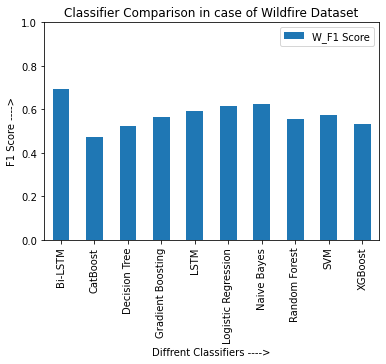

In [70]:
ax = tmp_df.plot.bar(x='Classifier', y='W_F1 Score', rot=90)
ax.set_ylim(0, 1)
ax.set_ylabel('F1 Score ---->')
ax.set_xlabel('Diffrent Classifiers ---->')
ax.set_title('Classifier Comparison in case of Wildfire Dataset')
plt.show()